# translation example

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from plots.plots import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu

% matplotlib inline

### Preparing data

In [2]:
eng = []
pt = []

with open("data/eng@pt.txt", "r") as f:
    for line in f:
        break_point = line.find("@")
        eng.append(line[:break_point])
        pt.append(line[break_point+1:].strip())
        
eng_pt_pairs = [(e,p) for e,p in zip(eng, pt)]

In [3]:
valid_break = int(len(eng_pt_pairs) * 0.8)
test_break = valid_break + int((len(eng_pt_pairs) - valid_break) * 0.5)


train_pairs = eng_pt_pairs[:valid_break]
valid_pairs = eng_pt_pairs[valid_break:test_break]
test_pairs = eng_pt_pairs[test_break:]

In [4]:
print("training size = ", len(train_pairs))
print("valid size = ", len(valid_pairs))
print("test size = ", len(test_pairs))

training size =  96840
valid size =  12105
test size =  12106


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'[+-]?\d+(?:\.\d+)?', "N", s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub('[^a-zA-z0-9\s]', '', s)
    return s

In [7]:
print("===Before===")

for t in train_pairs[0:4]:
    p1, p2 = t[0], t[1]
    print(p2)
    
print("===After===")

for t in train_pairs[0:4]:
    p1, p2 = t[0], t[1]
    p1 = normalizeString(p1)
    p2 = normalizeString(p2)
    print(p2)



===Before===
Vai.
Vá.
Oi.
Corre!
===After===
vai 
va 
oi 
corre 


In [8]:
train_pairs_nor = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in train_pairs]
valid_pairs_nor = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in valid_pairs]
test_pairs_nor = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in test_pairs]

In [9]:
all_text_pairs_en = [s1 for s1,_ in train_pairs_nor] + [s1 for s1,_ in valid_pairs_nor] + [s1 for s1,_ in valid_pairs_nor]
all_text_pairs_pt = [s1 for _,s1 in train_pairs_nor] + [s1 for _,s1 in valid_pairs_nor] + [s1 for _,s1 in valid_pairs_nor]
all_text_pairs = list(zip(all_text_pairs_en, all_text_pairs_pt))

In [10]:
en_sizes  = [len(s.split(" ")) for s in all_text_pairs_en]
pt_sizes  = [len(s.split(" ")) for s in all_text_pairs_pt]

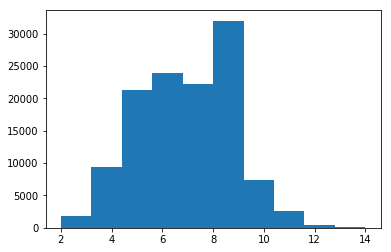

In [11]:
plt.hist(en_sizes)
plt.show()

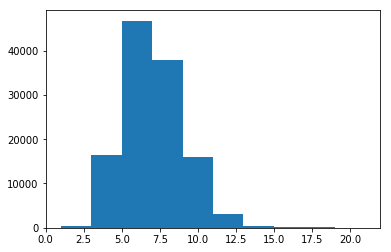

In [12]:
plt.hist(pt_sizes)
plt.show()

In [13]:
MAX_LENGTH = 8

In [14]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [15]:
def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [16]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [17]:
_, _, train_pairs_nor_f = prepareData("eng",
                                     "pt",
                                     train_pairs_nor)
print()


input_lang, output_lang, _ = prepareData("eng",
                               "pt",
                               all_text_pairs)

print()

_, _, valid_pairs_nor_f = prepareData("eng",
                                  "pt",
                                  valid_pairs_nor)



print()

_, _, test_pairs_nor_f = prepareData("eng",
                                  "pt",
                                  test_pairs_nor)

Read 96840 sentence pairs
Trimmed to 70333 sentence pairs
Counting words...
Counted words:
eng 7819
pt 12612

Read 121050 sentence pairs
Trimmed to 71287 sentence pairs
Counting words...
Counted words:
eng 7972
pt 12812

Read 12105 sentence pairs
Trimmed to 477 sentence pairs
Counting words...
Counted words:
eng 1008
pt 1146

Read 12106 sentence pairs
Trimmed to 22 sentence pairs
Counting words...
Counted words:
eng 108
pt 107


### sentences 2 tensors

In [18]:
example = random.choice(train_pairs_nor_f)
print(example)

('this book costs N N yen ', 'este livro custa N ienes ')


In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [20]:
indexesFromSentence(input_lang,example[0])

[118, 933, 3166, 242, 242, 713, 3]

In [21]:
indexesFromSentence(output_lang, example[1])

[894, 1628, 1228, 436, 1229, 3]

In [22]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [23]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[ 118],
        [ 933],
        [3166],
        [ 242],
        [ 242],
        [ 713],
        [   3],
        [   1]])

torch.Size([8, 1])
torch.int64
tensor([[ 894],
        [1628],
        [1228],
        [ 436],
        [1229],
        [   3],
        [   1]])

torch.Size([7, 1])
torch.int64


In [24]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [25]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[ 118],
        [ 933],
        [3166],
        [ 242],
        [ 242],
        [ 713],
        [   3],
        [   1]])

torch.Size([8, 1])
torch.int64

output

tensor([[ 894],
        [1628],
        [1228],
        [ 436],
        [1229],
        [   3],
        [   1]])

torch.Size([7, 1])
torch.int64


In [60]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size,
                                      hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, self.num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [61]:
hidden_size = 10
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [65]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([8, 1]) torch.int64
h0: torch.Size([1, 1, 10]) torch.float32


In [66]:
max_length = MAX_LENGTH
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 10]) torch.float32
hidden_enc: torch.Size([1, 1, 10]) torch.float32


In [67]:
class DecoderRNN(nn.Module):
    def __init__(self,
                 hidden_size,
                 output_size,
                 num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, self.num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [68]:
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 12812]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32


## Calculate loss over each token of the target language

In [69]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [70]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [71]:
def get_loss(input_tensor,
             target_tensor,
             encoder,
             decoder,
             criterion,
             max_length):

    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        _, topone = decoder_output.topk(1)
        decoder_input = topone.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    return loss.item() / target_length

Test get loss

In [73]:
valid_pairs = [tensorsFromPair(pair) for pair in valid_pairs_nor_f[0:100]]
valid_loss = []
for t in valid_pairs:
    input_sen, output_sen = t
    loss = get_loss(input_sen,
                    output_sen,
                    encoder,
                    decoder,
                    criterion,
                    MAX_LENGTH)
    valid_loss.append(loss)
print("mean loss", np.mean(valid_loss))

mean loss 9.420888965879168


In [74]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

Test train

0m 9s


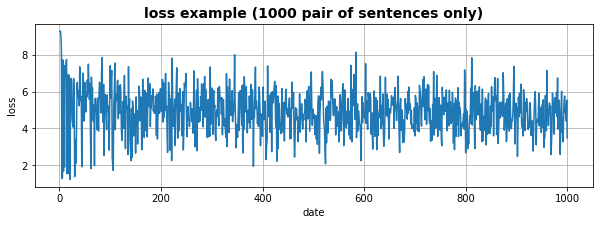

In [75]:
n_iters = 1000
training_pairs_little = [tensorsFromPair(random.choice(train_pairs_nor_f)) for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs_little:
    input_sen, output_sen = t    
    loss = train(input_sen,
                 output_sen,
                 encoder,
                 decoder,
                 encoder_optimizer,
                 decoder_optimizer,
                 criterion,
                 max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [76]:
def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               valid_pairs,
               encoder_path,
               decoder_path,
               batch_size=32,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []
    valid_loss = float("inf")
    
    

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            valid_batch = [tensorsFromPair(random.choice(valid_pairs))
                           for i in range(batch_size)]
            batch_loss = 0
            for t in valid_batch:
                input_sen, output_sen = t
                batch_loss += get_loss(input_sen,
                                       output_sen,
                                       encoder,
                                       decoder,
                                       criterion,
                                       MAX_LENGTH)
            current_valid_loss = batch_loss / batch_size
            
            if current_valid_loss < valid_loss:
                valid_loss = current_valid_loss
                torch.save(encoder.state_dict(), encoder_path)
                torch.save(decoder.state_dict(), decoder_path)
            print("mean training loss = {:.2f}".format(np.mean(plot_losses)))
            print("mean valid loss = {:.2f}".format(current_valid_loss))
            print("time in {} steps:".format(status_every), timeSince(start))
            print()
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


mean training loss = 4.73
mean valid loss = 5.70
time in 100 steps: 0m 1s

mean training loss = 4.87
mean valid loss = 5.05
time in 100 steps: 0m 1s

mean training loss = 4.57
mean valid loss = 4.81
time in 100 steps: 0m 1s

mean training loss = 4.49
mean valid loss = 4.76
time in 100 steps: 0m 1s

mean training loss = 4.61
mean valid loss = 5.38
time in 100 steps: 0m 1s

mean training loss = 4.69
mean valid loss = 4.60
time in 100 steps: 0m 1s

mean training loss = 4.44
mean valid loss = 5.16
time in 100 steps: 0m 1s

mean training loss = 4.72
mean valid loss = 4.94
time in 100 steps: 0m 1s

mean training loss = 4.57
mean valid loss = 5.09
time in 100 steps: 0m 1s



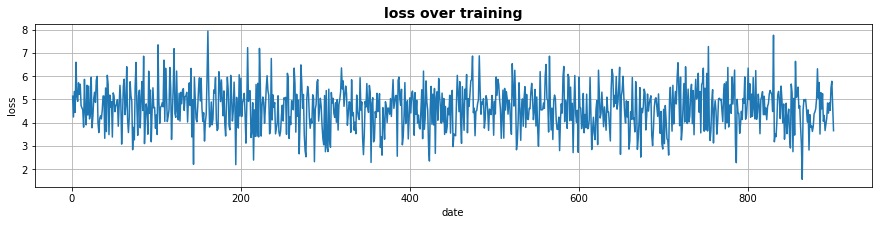

In [77]:
trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=1000,
           pairs=train_pairs_nor_f,
           valid_pairs=valid_pairs_nor_f,
           encoder_path="encoder.pkl",
           decoder_path="decoder.pkl",
           batch_size=32,
           status_every=100,
           learning_rate=0.01,
           teacher_forcing_ratio=0.5)

## translating

In [78]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model

In [79]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

np.random.shuffle(train_pairs_nor_f)

In [80]:
for t in train_pairs_nor_f[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : everybody has weaknesses 
neural translation : microprocessador chacoalhou microprocessador chacoalhou milionario esquecamo mosca esquecamo
reference translation : todo mundo tem fraquezas  <EOS>
blue score = 0.00

input_sentence : you ve done more than enough 
neural translation : microprocessador microprocessador chacoalhou desmaiei mosca nadador compensado compensado
reference translation : fizeste mais que o bastante  <EOS>
blue score = 0.00

input_sentence : did you understand everything 
neural translation : microprocessador cantora acenei nadador plastico reencheu acenei nadador
reference translation : voce entendeu tudo  <EOS>
blue score = 0.00



## Training some models and observing its translation

In [81]:
def save_translation(pairs, encoder, decoder, max_length, out_path):
    with open(out_path, "w") as file:
        file.write("source,candidate,reference,blue,accuracy\n")        
        for tuple_ in pairs:
            source, reference = tuple_
            candidate = translate(encoder,
                                  decoder,
                                  source,
                                  max_length=max_length)
            reference =  reference + ' <EOS>'
            blue = sentence_bleu([reference.split(" ")], candidate.split(" "))
            if blue >= 0.95:
                acc = 1
            else:
                acc = 0
            line = source + ","
            line += candidate + ","
            line += reference + ","
            line += "{:.3f},".format(blue)
            line += "{}\n".format(acc)
            file.write(line)

Test save_translation

In [82]:
save_translation(train_pairs_nor_f[0:3],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "temp.csv")

### Training 1

In [ ]:
hidden_size = 100
num_layers = 1

encoder = EncoderRNN(eng_enc_v_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, eng_dec_v_size, num_layers)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=train_pairs_nor_f,
           valid_pairs=valid_pairs_nor_f,
           encoder_path="encoder1.pkl",
           decoder_path="decoder1.pkl",
           status_every=200,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


np.random.shuffle(train_pairs_nor_f)

save_translation(train_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training1.csv")



df_results = pd.read_csv("training1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

### Evaluating the trained models

In [ ]:
hidden_size = 100
num_layers = 1

encoder = EncoderRNN(eng_enc_v_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, eng_dec_v_size, num_layers)


encoder.load_state_dict(torch.load("encoder1.pkl"))
decoder.load_state_dict(torch.load("decoder1.pkl"))

np.random.shuffle(valid_pairs_nor_f)

save_translation(valid_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "valid1.csv")

df_results = pd.read_csv("valid1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

## Training 2

In [84]:
hidden_size = 300
num_layers = 3

encoder = EncoderRNN(eng_enc_v_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, eng_dec_v_size, num_layers)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=train_pairs_nor_f,
           valid_pairs=valid_pairs_nor_f,
           encoder_path="encoder2.pkl",
           decoder_path="decoder2.pkl",
           status_every=200,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


np.random.shuffle(train_pairs_nor_f)

save_translation(train_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training2.csv")



df_results = pd.read_csv("training2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

mean training loss = 54.04
mean valid loss = 103.85
time in 200 steps: 0m 35s

mean training loss = 68.09
mean valid loss = 39.00
time in 200 steps: 0m 43s

mean training loss = 65.05
mean valid loss = 88.08
time in 200 steps: 0m 38s

mean training loss = 73.86
mean valid loss = 66.19
time in 200 steps: 0m 36s

mean training loss = 83.50
mean valid loss = 85.16
time in 200 steps: 0m 37s

mean training loss = 91.41
mean valid loss = 63.43
time in 200 steps: 0m 37s

mean training loss = 86.83
mean valid loss = 91.33
time in 200 steps: 0m 36s

mean training loss = 91.79
mean valid loss = 79.12
time in 200 steps: 0m 36s

mean training loss = 95.58
mean valid loss = 113.02
time in 200 steps: 0m 38s

mean training loss = 97.31
mean valid loss = 64.63
time in 200 steps: 0m 37s

mean training loss = 86.24
mean valid loss = 95.50
time in 200 steps: 0m 36s

mean training loss = 96.38
mean valid loss = 105.00
time in 200 steps: 0m 41s



KeyboardInterrupt: 

In [85]:
hidden_size = 100
num_layers = 3

encoder = EncoderRNN(eng_enc_v_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, eng_dec_v_size, num_layers)


encoder.load_state_dict(torch.load("encoder2.pkl"))
decoder.load_state_dict(torch.load("decoder2.pkl"))

np.random.shuffle(valid_pairs_nor_f)

save_translation(valid_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "valid2.csv")

df_results = pd.read_csv("valid2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

RuntimeError: Error(s) in loading state_dict for EncoderRNN:
	size mismatch for embedding.weight: copying a param of torch.Size([7972, 100]) from checkpoint, where the shape is torch.Size([7972, 300]) in current model.
	size mismatch for gru.weight_hh_l2: copying a param of torch.Size([300, 100]) from checkpoint, where the shape is torch.Size([900, 300]) in current model.
	size mismatch for gru.bias_hh_l0: copying a param of torch.Size([300]) from checkpoint, where the shape is torch.Size([900]) in current model.
	size mismatch for gru.weight_hh_l0: copying a param of torch.Size([300, 100]) from checkpoint, where the shape is torch.Size([900, 300]) in current model.
	size mismatch for gru.bias_hh_l1: copying a param of torch.Size([300]) from checkpoint, where the shape is torch.Size([900]) in current model.
	size mismatch for gru.weight_ih_l1: copying a param of torch.Size([300, 100]) from checkpoint, where the shape is torch.Size([900, 300]) in current model.
	size mismatch for gru.weight_hh_l1: copying a param of torch.Size([300, 100]) from checkpoint, where the shape is torch.Size([900, 300]) in current model.
	size mismatch for gru.bias_ih_l2: copying a param of torch.Size([300]) from checkpoint, where the shape is torch.Size([900]) in current model.
	size mismatch for gru.weight_ih_l2: copying a param of torch.Size([300, 100]) from checkpoint, where the shape is torch.Size([900, 300]) in current model.
	size mismatch for gru.bias_ih_l0: copying a param of torch.Size([300]) from checkpoint, where the shape is torch.Size([900]) in current model.
	size mismatch for gru.bias_ih_l1: copying a param of torch.Size([300]) from checkpoint, where the shape is torch.Size([900]) in current model.
	size mismatch for gru.weight_ih_l0: copying a param of torch.Size([300, 100]) from checkpoint, where the shape is torch.Size([900, 300]) in current model.
	size mismatch for gru.bias_hh_l2: copying a param of torch.Size([300]) from checkpoint, where the shape is torch.Size([900]) in current model.